In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [4]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.ImageFolder(root="C:\\Users\\Abhishek\\Downloads\\pokemon", transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [7]:
# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Generator and Discriminator models
netG = Generator().to(device)
netD = Discriminator().to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [9]:
# Define denormalize, show_images, and display_images functions
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # undo normalization ([-1, 1] -> [0, 1])
    return tensor.clamp(0, 1)

def show_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 10))
    for i, img in enumerate(images):
        axes[i].imshow(np.transpose(img, (1, 2, 0)))  # change the order of dimensions
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

def display_images(generator, dataloader, device, num_images=5):
    real_images, _ = next(iter(dataloader))  # Take a random batch from the dataloader
    real_images = real_images[:num_images]   # Get 'num_images' real images
    real_images = denormalize(real_images)   # Denormalize for displaying
    
    # Generate fake images
    noise = torch.randn(num_images, 100, 1, 1, device=device)  # Random noise
    fake_images = generator(noise).detach().cpu()  # Generate fake images
    fake_images = denormalize(fake_images)  # Denormalize for displaying
    
    # Show real images
    real_images_np = [real_images[i].numpy() for i in range(num_images)]
    show_images(real_images_np, title="Real Images")
    
    # Show generated (fake) images
    fake_images_np = [fake_images[i].numpy() for i in range(num_images)]
    show_images(fake_images_np, title="Generated (Fake) Images")

In [8]:
num_epochs = 150
real_label = 1.
fake_label = 0.

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Train Discriminator with real images
        netD.zero_grad()
        real_images = data[0].to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_images).view(-1)
        lossD_real = criterion(output, labels)
        lossD_real.backward()

        # Train Discriminator with fake images
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_images = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake_images.detach()).view(-1)
        lossD_fake = criterion(output, labels)
        lossD_fake.backward()
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        labels.fill_(real_label)
        output = netD(fake_images).view(-1)
        lossG = criterion(output, labels)
        lossG.backward()
        optimizerG.step()

    print(f'Epoch [{epoch}/{num_epochs}], Loss D: {lossD_real + lossD_fake}, Loss G: {lossG}')


Epoch [0/100], Loss D: 0.179692342877388, Loss G: 11.504534721374512
Epoch [1/100], Loss D: 0.022893548011779785, Loss G: 8.39699935913086
Epoch [2/100], Loss D: 0.05980607867240906, Loss G: 14.773151397705078
Epoch [3/100], Loss D: 1.0487356185913086, Loss G: 11.690814971923828
Epoch [4/100], Loss D: 0.7270821332931519, Loss G: 3.499077796936035
Epoch [5/100], Loss D: 0.5425077676773071, Loss G: 2.76273512840271
Epoch [6/100], Loss D: 2.0966742038726807, Loss G: 3.1942458152770996
Epoch [7/100], Loss D: 0.40007567405700684, Loss G: 3.1661903858184814
Epoch [8/100], Loss D: 0.7478069067001343, Loss G: 4.39295768737793
Epoch [9/100], Loss D: 0.4659321904182434, Loss G: 2.085195541381836
Epoch [10/100], Loss D: 0.623288631439209, Loss G: 2.8780524730682373
Epoch [11/100], Loss D: 0.9550633430480957, Loss G: 4.5212907791137695
Epoch [12/100], Loss D: 0.3652215600013733, Loss G: 3.894981861114502
Epoch [13/100], Loss D: 0.48332810401916504, Loss G: 3.9960317611694336
Epoch [14/100], Loss D

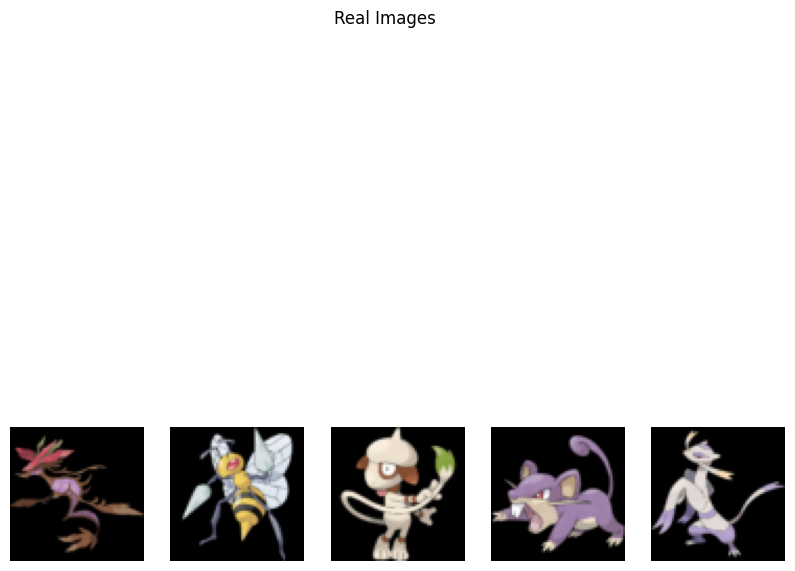

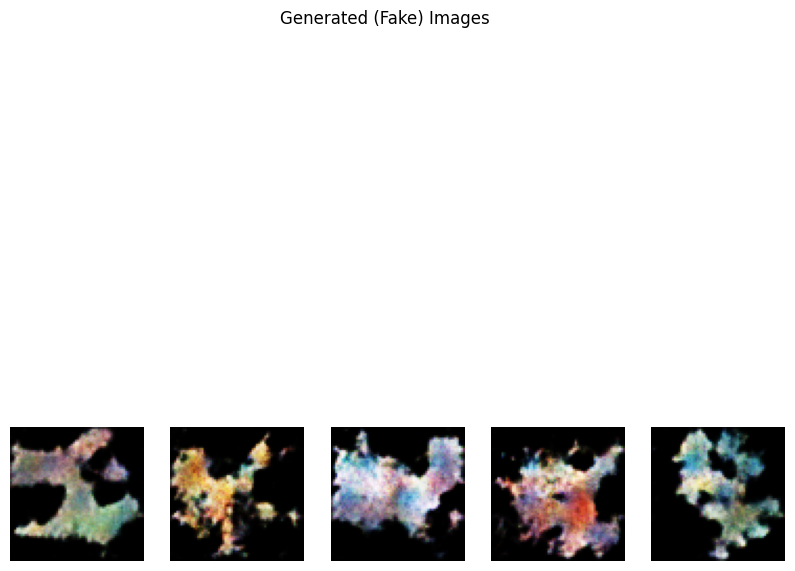

In [11]:
if (epoch+1) % 10 == 0:
    display_images(netG, dataloader, device)